In [1]:
import numpy as np
import matplotlib.pyplot as plt
import libstempo as T
import libstempo.plot as LP, libstempo.toasim as LT
import glob
import math
import json
from enterprise.signals import gp_signals
from enterprise_extensions import model_utils, blocks
import dynesty
from enterprise.signals import signal_base
from enterprise.pulsar import Pulsar
from enterprise_extensions.frequentist import optimal_statistic as opt_stat
import enterprise.signals.parameter as parameter
from enterprise.signals import white_signals

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
parfiles = sorted(glob.glob('/data/files/*.par'))
Npsr = len(parfiles)

In [3]:
psrs = []
Amp = 1e-15
gamma = 13./3.

for ii in range(0,Npsr):

    # years of observations
    psr = LT.fakepulsar(parfile=parfiles[ii], obstimes=np.arange(53000,53000+10*365.25,28.), toaerr=0.1)

    # We now remove the computed residuals from the TOAs, obtaining (in effect) a perfect realization of the deterministic timing model. The pulsar parameters will have changed somewhat, so `make_ideal` calls `fit()` on the pulsar object.
    LT.make_ideal(psr)

    #Generate white noise
    LT.add_efac(psr,efac=1.0)

    # add to list
    psrs.append(psr)


LT.createGWB(psrs, Amp=Amp, gam=gamma)

for Psr in psrs:

    Psr.savepar("/data/files/" + Psr.name + '.par')
    Psr.savetim("/data/files/" + Psr.name + '.tim')
    T.purgetim("/data/files/" + Psr.name + '.tim')


[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 
[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.


Results for PSR J1730-2304


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.000 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = nan	pre/post = 0
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       4.58299999999785          4.58299999999785          5.4716e-11    0             Y
RAJ (hms)       17:30:20.7738020           17:30:20.7738020         7.524e-07     0            
DECJ (rad)      0.403203673196531         0.403203673196531         6.7838e-11    0             Y
DECJ (dms)      +23:06:06.72753           +23:06:06.72753           1.3993e-05    0            
F

In [4]:
parfiles = sorted(glob.glob('/data/files/*.par'))
timfiles = sorted(glob.glob('/data/files/*.tim'))

psrs = []
ephemeris = None
for p, t in zip(parfiles, timfiles):
    psr = Pulsar(p, t, ephem=ephemeris)
    psrs.append(psr)

                 1.54731910978365e-19      0             1.5473e-19    N
EPHVER          TEMPO2                    TEMPO2                    
NE_SW (cm^-3)   4                         4                         0             0             N
DM_SERIES       TAYLOR                   
---------------------------------------------------------------------------------------------------
[textOutput.C:308] Notice: Parameter uncertainties NOT multiplied by sqrt(red. chisq)


Derived parameters:

P0 (s)      = 0.00486545328280592       1.8711e-18   
P1          = 1.01931851309847e-20      1.1529e-26   
tau_c (Myr) = 7567.9
bs (G)      = 2.2535e+08

Total proper motion = 6.4359 +/- 0.0027777 mas/yr
Total time span = 3640.000 days = 9.966 years

Tempo2 usage
Units:                 TCB (tempo2)
Time ephemeris:        IF99 (tempo2)
Troposphere corr.?     Yes (tempo2)
Dilate freq?           Yes (tempo2)
Electron density (1AU) 4
Solar system ephem     DE414
Time scale             TT(TAI)
Binary model  

In [5]:
# find the maximum time span to set GW frequency sampling
Tspan = model_utils.get_tspan(psrs)

# Here we build the signal model
# First we add the timing model
s = gp_signals.TimingModel()

# Then we add the white noise
# We use different white noise parameters for every backend/receiver combination
# The white noise parameters are held constant
efac = parameter.Constant(1.0)
s += white_signals.MeasurementNoise(efac=efac)

# Finally, we add the common red noise, which is modeled as a Fourier series with 30 frequency components
# The common red noise has a power-law PSD with spectral index of 4.33
s += blocks.common_red_noise_block(psd='powerlaw', prior='log-uniform', Tspan=Tspan, components=30, name='gw_crn', orf = None)

# We set up the PTA object using the signal we defined above and the pulsars
pta = signal_base.PTA([s(p) for p in psrs])

In [6]:
pta.params

[gw_crn_gamma:Uniform(pmin=0, pmax=7),
 gw_crn_log10_A:Uniform(pmin=-18, pmax=-11)]

In [12]:
#%% Nested Sampling with dynesty

def TransformPrior(theta, verbose=False):
	if verbose:
		print('\n', len(theta), '\n')
	ph_pars = np.zeros(len(theta))
	idx_offset = 0
	for i, nm in enumerate(pta.params):
		if nm.size and nm.size>1:
			for j in range(nm.size):
				ph_pars[i+idx_offset] = (pta.params[i].prior.func_kwargs['pmax'] - pta.params[i].prior.func_kwargs['pmin']) * theta[i+idx_offset] + pta.params[i].prior.func_kwargs['pmin']
				idx_offset+=1
		else:
			ph_pars[i+idx_offset] = ( pta.params[i].prior.func_kwargs['pmax'] - pta.params[i].prior.func_kwargs['pmin'])*theta[i+idx_offset] + pta.params[i].prior.func_kwargs['pmin']
		if verbose:
			print(nm, pta.params[i].prior.func_args, pta.params[i].prior.func_kwargs['pmin'], pta.params[i].prior.func_kwargs['pmax'])
	return ph_pars

def log_l(x):
	return pta.get_lnlikelihood(x)

ndim = len(pta.params)
# initialize sampler with pool with pre-defined queue

Npar = len(pta.params)

sampler = dynesty.NestedSampler(log_l, TransformPrior, ndim=Npar, nlive=500, bound='multi', sample='rwalk')

sampler.run_nested(dlogz=0.1)

3431it [00:27, 125.50it/s, +500 | bound: 22 | nc: 1 | ncall: 54586 | eff(%):  7.268 | loglstar:   -inf < 4680.646 <    inf | logz: 4676.135 +/-  0.083 | dlogz:  0.000 >  0.100]


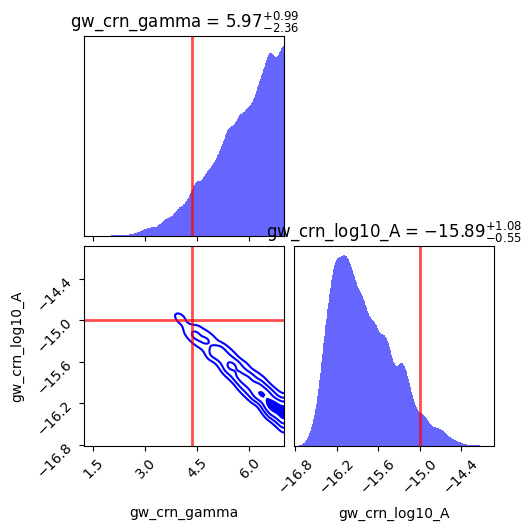

In [13]:
from dynesty import plotting as dyplot
results = sampler.results
fig, axes = dyplot.cornerplot(results,
                             show_titles=True, truths = [gamma, np.log10(Amp)], labels=pta.param_names, color='blue',
                             quantiles=None)

In [14]:
#correlation curve assuming the injected parameters
ml_params = {"gw_crn_gamma": gamma, "gw_crn_log10_A": np.log10(Amp)}
ostat = opt_stat.OptimalStatistic(psrs, pta=pta, orf='hd')
xi, rho, sig, OS, OS_sig = ostat.compute_os(params=ml_params)

In [15]:
# Plot the cross-correlations and compare to the Hellings-Downs curve
# Before plotting, we need to bin the cross-correlations

def weightedavg(rho, sig):
    weights, avg = 0., 0.
    for r,s in zip(rho,sig):
        weights += 1./(s*s)
        avg += r/(s*s)

    return avg/weights, np.sqrt(1./weights)

def bin_crosscorr(zeta, xi, rho, sig):

    rho_avg, sig_avg = np.zeros(len(zeta)), np.zeros(len(zeta))

    for i,z in enumerate(zeta[:-1]):
        myrhos, mysigs = [], []
        for x,r,s in zip(xi,rho,sig):
            if x >= z and x < (z+10.):
                myrhos.append(r)
                mysigs.append(s)
        rho_avg[i], sig_avg[i] = weightedavg(myrhos, mysigs)

    return rho_avg, sig_avg

# sort the cross-correlations by xi
idx = np.argsort(xi)

xi_sorted = xi[idx]
rho_sorted = rho[idx]
sig_sorted = sig[idx]

# bin the cross-correlations so that there are the same number of pairs per bin
npairs = 40

xi_mean = []
xi_err = []

rho_avg = []
sig_avg = []

i = 0
while i < len(xi_sorted):

    xi_mean.append(np.mean(xi_sorted[i:npairs+i]))
    xi_err.append(np.std(xi_sorted[i:npairs+i]))

    r, s = weightedavg(rho_sorted[i:npairs+i], sig_sorted[i:npairs+i])
    rho_avg.append(r)
    sig_avg.append(s)

    i += npairs

xi_mean = np.array(xi_mean)
xi_err = np.array(xi_err)

def get_HD_curve(zeta):

    coszeta = np.cos(zeta*np.pi/180.)
    xip = (1.-coszeta) / 2.
    HD = 3.*( 1./3. + xip * ( np.log(xip) -1./6.) )

    return HD/2

(-5e-30, 5e-30)

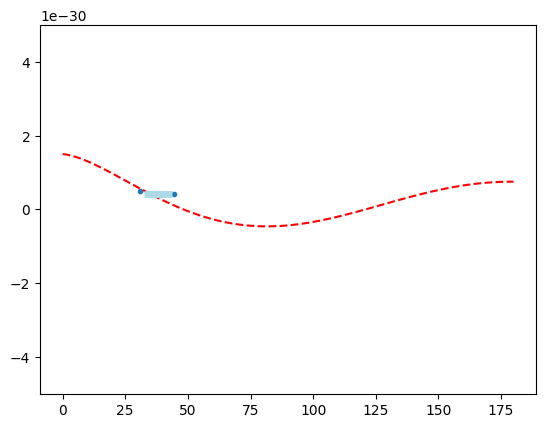

In [16]:
plt.plot(xi*180/np.pi, rho, '.')
zeta = np.linspace(0.01,180,100)
HD = get_HD_curve(zeta+1)
plt.plot(zeta, OS*HD, ls='--', label='Hellings-Downs', color='red', lw=1.5)
plt.errorbar(xi_mean*180/np.pi, rho_avg, xerr=xi_err*180/np.pi, color = "lightblue", lw = 5)

plt.ylim(-5e-30,5e-30)